In [6]:
import numpy as np
import os
import scipy.io as sio
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
from matplotlib import pyplot as plt

In [156]:
#run all functions from here.

unpack_precision_mats() # create single subject precision FC matrices

# At this point, run merge_precision_mats.m to create separate matrices based on
# diagnosis that are also arranged by subject/sesion (save to /precision/stroke and /precision/controls)

cwd = os.getcwd()
data_dir = str(cwd) + '/data'
fc_dir =data_dir + '/precision/'
subtype=['stroke', 'control']

for dx in subtype:
    fc=sio.loadmat(fc_dir + dx + '/C_precision.mat')

    fc=fc['C_precision']
    intervals=[[0, 1], [1, 2], [2, 3], [3, 4]] #time point comparisons. 0=1, 1=2, etc.
 
    for i in range(0, 4):
        process_data(intervals[i], fc, dx)

/Users/emilyolafson/GIT/stroke-graph-matching/results/jupyter/precision/
stroke
S1
S2
.txt
/Users/emilyolafson/GIT/stroke-graph-matching/results/jupyter/precision/
stroke
S2
S3
.txt
/Users/emilyolafson/GIT/stroke-graph-matching/results/jupyter/precision/
stroke
S3
S4
.txt
/Users/emilyolafson/GIT/stroke-graph-matching/results/jupyter/precision/
stroke
S4
S5
.txt
/Users/emilyolafson/GIT/stroke-graph-matching/results/jupyter/precision/
control
S1
S2
.txt
/Users/emilyolafson/GIT/stroke-graph-matching/results/jupyter/precision/
control
S2
S3
.txt
/Users/emilyolafson/GIT/stroke-graph-matching/results/jupyter/precision/
control
S3
S4
.txt
/Users/emilyolafson/GIT/stroke-graph-matching/results/jupyter/precision/
control
S4
S5
.txt


In [155]:
def remap_cost(interval, fc):
    """Cost function: the cost of remapping each node in matrix A to every other node in matrix B. 
        Output is fed into graph matching algorithm"""
    costmat_all=list()

    nROIs=fc[0][0].shape[0]
    #calculate cost between all ROIs
    for i in range(0,fc.shape[0]): #subject 
        if (dx == 'stroke' and i==5 and interval == [3,4]): #sub6 has no 4,5
            continue
        if (dx == 'stroke' and i==11 and (interval == [3,4] or interval == [2,3])): #sub12 has no 4,5 OR 3,4
            continue
        if (dx == 'stroke' and i==19 and (interval == [3,4] or interval == [2,3] or interval == [1,2])): #sub20 has no 4,5 OR 3,4 OR 2,3
            continue
        costmat=np.zeros((nROIs,nROIs))
        
        for x in range(0,nROIs): #x = time point 1.
            a=fc[i,interval[0]][x]
            
            for y in range(0,nROIs): #y = time point 2.
                b=fc[i,interval[1]][y]
                
                costmat[x,y]=distance.euclidean(a,b)
        costmat_all.append(costmat)
        
    return [costmat_all, nROIs]


def graph_matching(costmat_all, interval, nROIs, dx):
    """Runs graph matching w/ the Hungarian algorithm and saves outputs:
    
        cols_SXSY.txt - each row is a different subject. Values in each column represent the node
        in the latter time point that the node in the prior time point was mapped to.
        
        roichanges_SXSY.txt - each row is a different subject. Values in each column represent 
        whether the node was remapped to a DIFFERENT node than itself in the subsequent time point 
        (elements are 0 or 1, 1 if the node was remapped to a different node and 0 if the node was mapped to itself.
        Used to calculate remap frequency for each region, when averaged vertically (across subjects)."""
    
    results_dir = str(cwd) + '/results/jupyter/precision/'

    nROIs=fc[0][0].shape[0]
    nsubs=len(costmat_all) #test
    
    rows=np.zeros((nsubs,nROIs))
    cols=np.zeros((nsubs,nROIs))
    roichanges=np.zeros((nsubs,nROIs))
    truecols=range(0,nROIs)

    for i in range(0, nsubs):
        cost=costmat_all[i]
        rowind, colind=linear_sum_assignment(cost) #graph matching part.
        rows[i]=rowind
        cols[i]=colind

    np.savetxt(results_dir+ dx +'/cols_'+ 'S'+str(interval[0]+1)+'S'+ str(interval[1]+1)+'.txt', cols)

    for j in range(0,nsubs):
        for i in range(0,nROIs):
            if cols[j][i]!=truecols[i]:
                roichanges[j][i]=1 #indices that are switched

    allchanges=np.mean(roichanges,0)
    np.savetxt(results_dir + dx +'/roichanges_' + 'S'+str(interval[0]+1)+'S'+ str(interval[1]+1) +'.txt', allchanges)

def unpack_precision_mats():
    """Turn concatenated precision FC matrix into multiple single subject/single session matrices.
    Save to /precision/ folder."""
    cwd = os.getcwd()
    data_dir = str(cwd) + '/data/'
    
    subj_all = np.genfromtxt(data_dir + 'subjects.txt', dtype = 'str') #list of subjects in same order as precision matrices are saved.    
    fc_dir = data_dir + '/precision/'
    output_prec = sio.loadmat(fc_dir + 'FCprec_concat_allsub.mat')
    prec = output_prec['C'] 
    c = 0
    for sub in subj_all:
        mdic = {"C": prec[c]}
        sio.savemat(fc_dir + sub, mdic)

def process_data(interval, fc, dx):
    """Calculate the cost of remapping across all subjects, and perform graph matching.
    Saves outputs to /results/jupyter/.../stroke and /controls."""
    [costmat_all, nROIs]=remap_cost(interval, fc)
    graph_matching(costmat_all, interval, nROIs, dx)

NameError: name 'costmat_all' is not defined

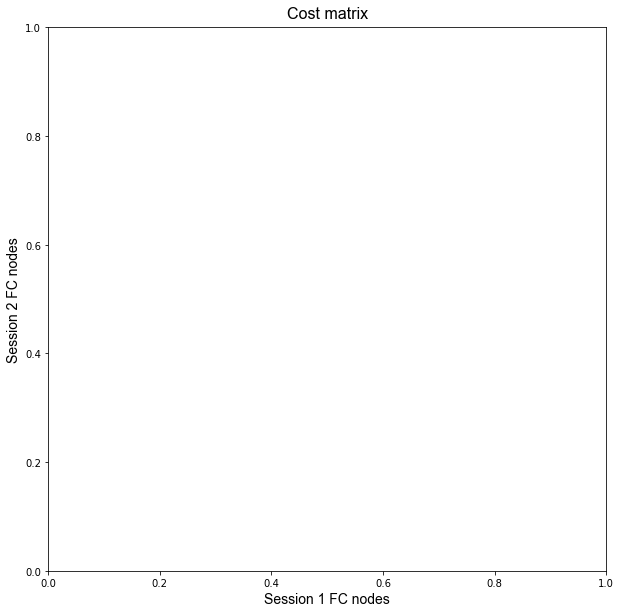

In [157]:
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'14'}


fig = plt.figure(figsize=(10, 10))
plt.ylabel("Session 2 FC nodes", **axis_font)
plt.xlabel("Session 1 FC nodes", **axis_font)
plt.title("Cost matrix", **title_font)

#plotting.plot_matrix(allsubs_nopenalty_S2S3[13], figure=fig)
plotting.plot_matrix(costmat_all[8], figure=fig)
